In [1]:
from tflite_runtime.interpreter import Interpreter
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display,Image

import tflite_runtime
print(tflite_runtime.__version__)

2.14.0


In [2]:
# Load model
interpreter = Interpreter(model_path="coco_ssd_mobilenet_v1_1.0_quant_2018_06_29/detect.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]
floating_model = (input_details[0]['dtype'] == np.float32)

input_mean = 127.5
input_std = 127.5
# Check output layer name to determine if this model was created with TF2 or TF1,
# because outputs are ordered differently for TF2 and TF1 models
outname = output_details[0]['name']

if ('StatefulPartitionedCall' in outname): # This is a TF2 model
    boxes_idx, classes_idx, scores_idx = 1, 3, 0
else: # This is a TF1 model
    boxes_idx, classes_idx, scores_idx = 0, 1, 2

# un-comment to see the details
print(input_details, output_details, height, width)

[{'name': 'normalized_input_image_tensor', 'index': 175, 'shape': array([  1, 300, 300,   3], dtype=int32), 'shape_signature': array([  1, 300, 300,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 128), 'quantization_parameters': {'scales': array([0.0078125], dtype=float32), 'zero_points': array([128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] [{'name': 'TFLite_Detection_PostProcess', 'index': 167, 'shape': array([ 1, 10,  4], dtype=int32), 'shape_signature': array([ 1, 10,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'TFLite_Detection_PostProcess:1', 'index': 168, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parame

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
# Load the label map
with open("coco_ssd_mobilenet_v1_1.0_quant_2018_06_29/labelmap.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Have to do a weird fix for label map if using the COCO "starter model" from
# https://www.tensorflow.org/lite/models/object_detection/overview
# First label is '???', which has to be removed.
if labels[0] == '???':
    del(labels[0])

In [4]:
# Check labels
print(len(labels))
print(labels)

90
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', '???', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', '???', 'backpack', 'umbrella', '???', '???', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', '???', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', '???', 'dining table', '???', '???', 'toilet', '???', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', '???', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [5]:
min_conf_threshold = 0.5 # adjust as necessary

In [6]:
# Start the video capture
cam=cv2.VideoCapture(1)
dispW = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
dispH = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


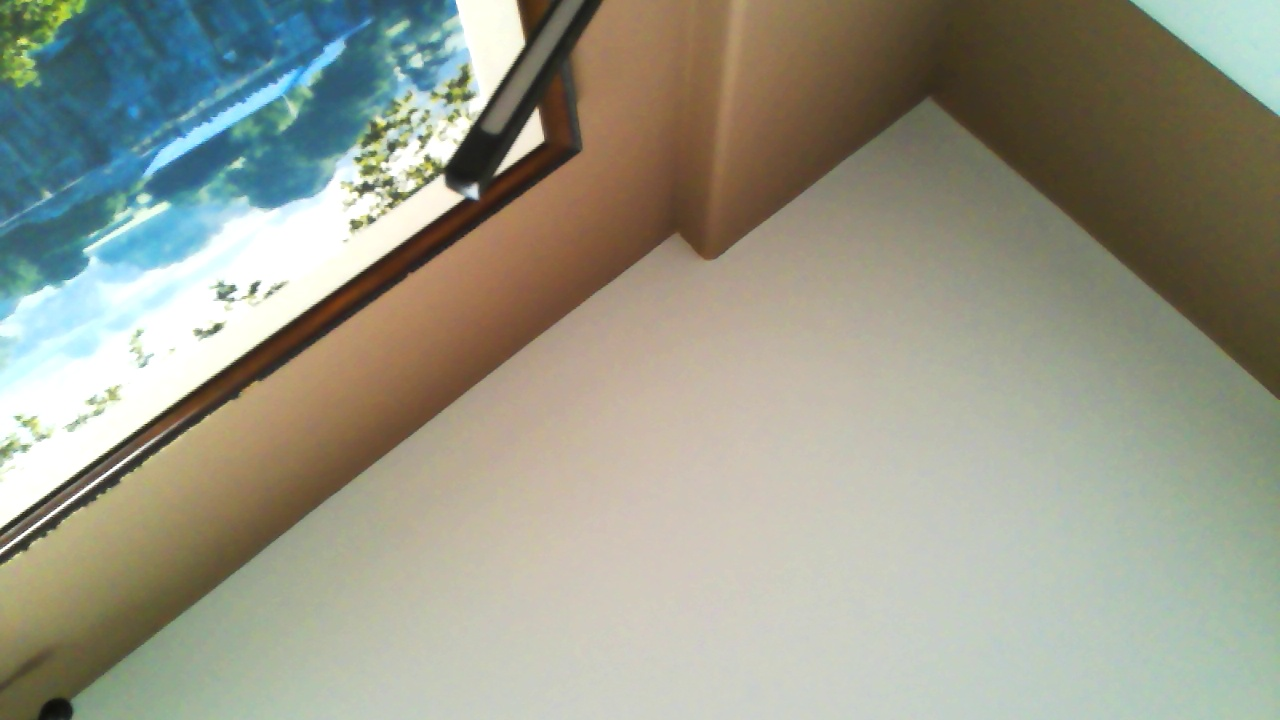

In [7]:
# Start the IPython display
display_handle=display(None, display_id=True)    

In [ ]:
try:
    while True:
        # Read the next frame
        _, frame = cam.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image

        # Convert to RGB
        #frameSmall = cv2.resize(frame,(0,0), fx=scale, fy=scale)
        frameSmall = cv2.resize(frame, (height, width))
        frameRGB = cv2.cvtColor(frameSmall, cv2.COLOR_BGR2RGB)

        input_data = np.expand_dims(frameRGB, axis=0)
        # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
        if floating_model:
            input_data = (np.float32(input_data) - input_mean) / input_std
        
        # Perform the actual detection by running the model with the image as input
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        # Retrieve detection results
        boxes = interpreter.get_tensor(output_details[boxes_idx]['index'])[0] # Bounding box coordinates of detected objects
        classes = interpreter.get_tensor(output_details[classes_idx]['index'])[0]+1 # Class index of detected objects
        scores = interpreter.get_tensor(output_details[scores_idx]['index'])[0] # Confidence of detected objects

        # Loop over for first 5 detections and draw detection box if confidence is above minimum threshold
        if sum(x>min_conf_threshold for x in scores) > 5:
            print("too many objects!")
            continue
            
        for i in range(len(scores)):
            if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):
    
                # Get bounding box coordinates and draw box
                # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
                ymin = int(max(1,(boxes[i][0] * dispH)))
                xmin = int(max(1,(boxes[i][1] * dispW)))
                ymax = int(min(dispH,(boxes[i][2] * dispH)))
                xmax = int(min(dispW,(boxes[i][3] * dispW)))
    
                cv2.rectangle(frame, (xmin,ymin), (xmax,ymax), (255, 0, 255), 2)
    
                # Draw label
                object_name = labels[int(classes[i])-1] # Look up object name from "labels" array using class index
                label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
                labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2) # Get font size
                label_ymin = max(ymin, labelSize[1] + 15) # Make sure not to draw label too close to top of window
                cv2.rectangle(frame, (xmin, label_ymin-labelSize[1]-15), (xmin+labelSize[0], label_ymin+baseLine-15), (255, 0, 255), 2) # Draw box for label text
                cv2.putText(frame, label, (xmin, label_ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 255), 2) # Draw label text
     
                xcenter = (xmax+xmin)/2
                ycenter = (ymax+ymin)/2
                print("Label, (X, Y), max(X, Y) = {}, ({}, {}), ({}, {})".format(object_name, xcenter, ycenter, dispW, dispH))

        # Display as jpeg image
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    cam.release()
    display_handle.update(None) 


Label, (X, Y), max(X, Y) = tv, (608.0, 180.5), (1280, 720)
Label, (X, Y), max(X, Y) = tv, (608.0, 194.0), (1280, 720)
Label, (X, Y), max(X, Y) = tv, (620.0, 188.5), (1280, 720)
Label, (X, Y), max(X, Y) = tv, (625.5, 191.0), (1280, 720)
Label, (X, Y), max(X, Y) = tv, (640.5, 303.0), (1280, 720)
Label, (X, Y), max(X, Y) = person, (633.5, 171.5), (1280, 720)
Label, (X, Y), max(X, Y) = tv, (625.5, 194.0), (1280, 720)
Label, (X, Y), max(X, Y) = tv, (632.5, 196.5), (1280, 720)
Label, (X, Y), max(X, Y) = tv, (632.5, 202.0), (1280, 720)
Label, (X, Y), max(X, Y) = tv, (639.5, 204.5), (1280, 720)
Label, (X, Y), max(X, Y) = airplane, (640.5, 265.5), (1280, 720)
Label, (X, Y), max(X, Y) = airplane, (640.5, 276.5), (1280, 720)
Label, (X, Y), max(X, Y) = airplane, (640.5, 282.0), (1280, 720)
Label, (X, Y), max(X, Y) = airplane, (640.5, 282.0), (1280, 720)
Label, (X, Y), max(X, Y) = airplane, (640.5, 282.0), (1280, 720)
Label, (X, Y), max(X, Y) = airplane, (640.5, 282.0), (1280, 720)
Label, (X, Y), m